# American Sign Language (ASL) Translator

## Imports

In [ ]:
!pip install mediapipe
!pip install tensorflow
!pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

# Upload kaggle.json on each runtime
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ayuraj/asl-dataset
!unzip asl-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0

In [ ]:
!rm asl_dataset/asl_dataset -r

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sn
import tensorflow as tf

from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.metrics import Accuracy, Precision, Recall
from keras.layers import Conv2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras import Sequential
from sklearn.preprocessing import OneHotEncoder


## Preprocessing

In [ ]:
path = "/content/asl_dataset"
data, label = [], []

for root, dirs, files in os.walk(path):
  key = os.path.basename(root)

  for f in files:
    full_path = os.path.join(root, f)

    img = cv2.imread(full_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    data.append(img)
    label.append(key)

data = np.array(data)
label = np.array(label)

x_train, x_extra, y_train, y_extra = train_test_split(data, label, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_extra, y_extra, test_size=0.5)

In [ ]:
# Double check sizes of everything
print(x_train.shape, y_train.shape)

print(x_test.shape, y_test.shape)

print(x_val.shape, y_val.shape)

(2012, 128, 128, 3) (2012,)
(251, 128, 128, 3) (251,)
(252, 128, 128, 3) (252,)


In [ ]:
# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

In [ ]:
# Encoding labels from str to int
encoder = OneHotEncoder()

encoder.fit(y_train.reshape(-1,1))

y_train = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.reshape(-1,1)).toarray()
y_val = encoder.transform(y_val.reshape(-1,1)).toarray()

In [ ]:
# Double check sizes of everything
print(x_train.shape, y_train.shape)

print(x_test.shape, y_test.shape)

print(x_val.shape, y_val.shape)

(2012, 128, 128, 3) (2012, 36)
(251, 128, 128, 3) (251, 36)
(252, 128, 128, 3) (252, 36)


## Model Training and Validation

In [ ]:
num_classes = 36

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)),
  tf.keras.layers.AveragePooling2D(),

  tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
  tf.keras.layers.AveragePooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',keras.metrics.Precision(name='Precision'),keras.metrics.Recall(name="Recall")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 average_pooling2d (AverageP  (None, 62, 62, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 average_pooling2d_1 (Averag  (None, 29, 29, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [ ]:
history = model.fit(x_train,y_train,validation_data = (x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
63/63 [==============================] - 15s 34ms/step - loss: 1.1815 - acc: 0.6869 - Precision: 0.8789 - Recall: 0.5810 - val_loss: 0.4452 - val_acc: 0.8254 - val_Precision: 0.8947 - val_Recall: 0.8095
Epoch 2/10
63/63 [==============================] - 1s 20ms/step - loss: 0.2047 - acc: 0.9433 - Precision: 0.9508 - Recall: 0.9319 - val_loss: 0.3280 - val_acc: 0.8889 - val_Precision: 0.9250 - val_Recall: 0.8810
Epoch 3/10
63/63 [==============================] - 1s 20ms/step - loss: 0.1080 - acc: 0.9717 - Precision: 0.9750 - Recall: 0.9677 - val_loss: 0.1223 - val_acc: 0.9683 - val_Precision: 0.9799 - val_Recall: 0.9683
Epoch 4/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0424 - acc: 0.9876 - Precision: 0.9876 - Recall: 0.9866 - val_loss: 0.1741 - val_acc: 0.9405 - val_Precision: 0.9476 - val_Recall: 0.9325
Epoch 5/10
63/63 [==============================] - 2s 24ms/step - loss: 0.0254 - acc: 0.9911 - Precision: 0.9915 - Recall: 0.9911 - val_loss: 0.15

In [ ]:
loss, accuracy, prec, rec = model.evaluate(x_test, y_test)
print(accuracy, loss, prec, rec)

8/8 [==============================] - 0s 54ms/step - loss: 0.1573 - acc: 0.9562 - Precision: 0.9600 - Recall: 0.9562
0.9561753273010254 0.1572890728712082 0.9599999785423279 0.9561753273010254


## Training Results

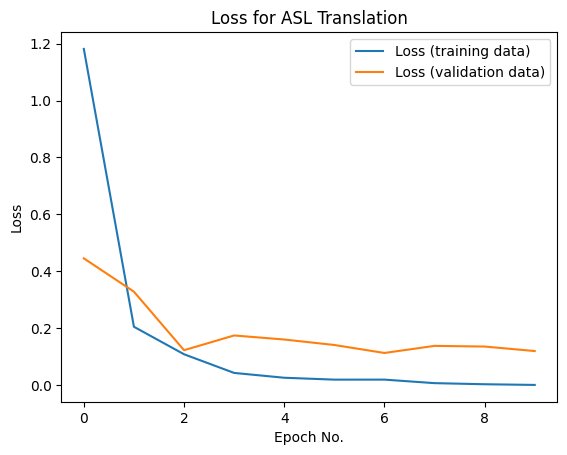

In [ ]:
# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for ASL Translation')
plt.ylabel('Loss')
plt.xlabel('Epoch No.')
plt.legend(loc="upper right")
plt.show()

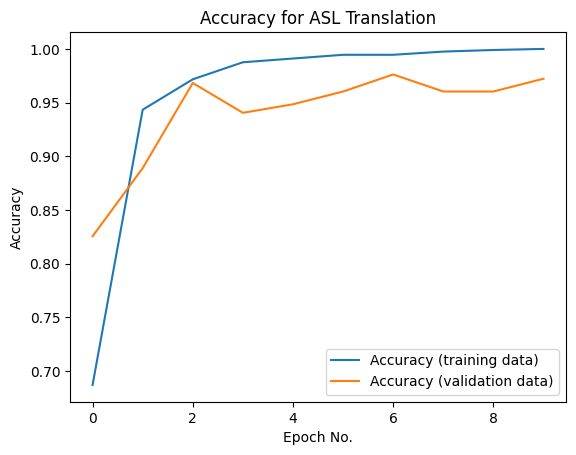

In [ ]:
# Plot history: Accuracy
plt.plot(history.history['acc'], label='Accuracy (training data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Accuracy for ASL Translation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch No.')
plt.legend(loc="lower right")
plt.show()